In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import pretty inbuilt print
from IPython.display import display
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [51]:
car_data = pd.read_csv('data/car.csv', sep=';')
customer_data = pd.read_csv('data/customer.csv', sep=';')

In [52]:
columns_to_keep =[
    'city08',
    'cylinders',
    'displ',
    'trany',
    'vclass',
    'year',
    'fueltype',
    'drive'
]

In [53]:
scalars = ['highway08', 'city08', 'cylinders', 'displ', 'year']
# remove scalars
categories = [col for col in columns_to_keep if col not in scalars]

# check if scalars are numeric
display(car_data[scalars].dtypes)
# check if categories are categorical
display(car_data[categories].dtypes)


highway08      int64
city08         int64
cylinders    float64
displ        float64
year           int64
dtype: object

trany       object
vclass      object
fueltype    object
drive       object
dtype: object

In [54]:
# display the number of unique values in each category
display(car_data[categories].nunique())

trany       40
vclass      34
fueltype    15
drive        7
dtype: int64

In [55]:
# car_data["cylinders"] = car_data["cylinders"].fillna(0)
# car_data["displ"] = car_data["displ"].fillna(0)
car_data["trany"] = car_data["trany"].fillna("EV")

# drop NA in drive
car_data = car_data[car_data["drive"].notna()]

# drop NA in cylinders
car_data = car_data[car_data["cylinders"].notna()]

# drop NA in displ
car_data = car_data[car_data["displ"].notna()]


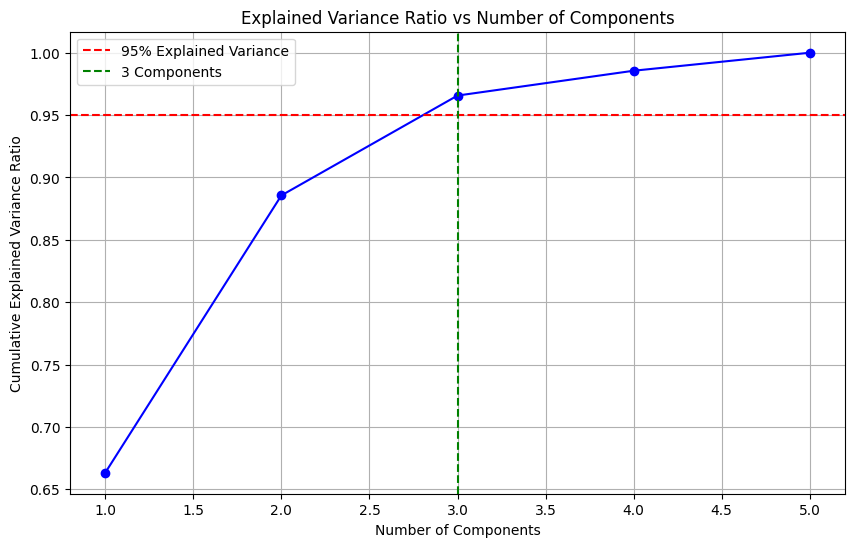

In [56]:
# standardize scalars
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric = scaler.fit_transform(car_data[scalars])

from sklearn.decomposition import PCA
# Initialize PCA without specifying n_components to keep all components initially
pca = PCA()
# Fit PCA
pca_result = pca.fit_transform(numeric)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Find number of components needed to explain 95% of variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Components')
plt.legend()
plt.grid(True)
plt.show()

# Refit PCA with optimal number of components
pca = PCA(n_components=n_components_95)
pca_result = pca.fit_transform(numeric)
pca_result = pd.DataFrame(pca_result)



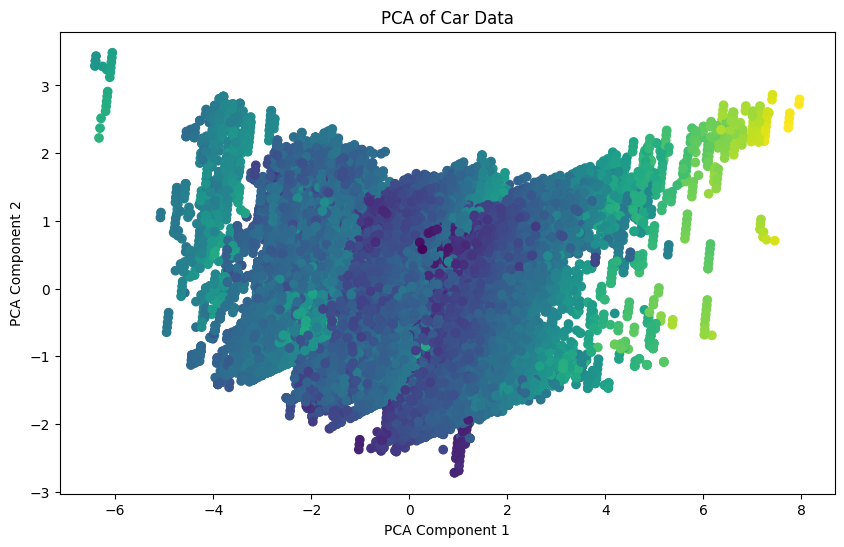

In [57]:
# plot pca result, map the third component to color
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[0], pca_result[1], c=pca_result[2])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Car Data')
plt.show()

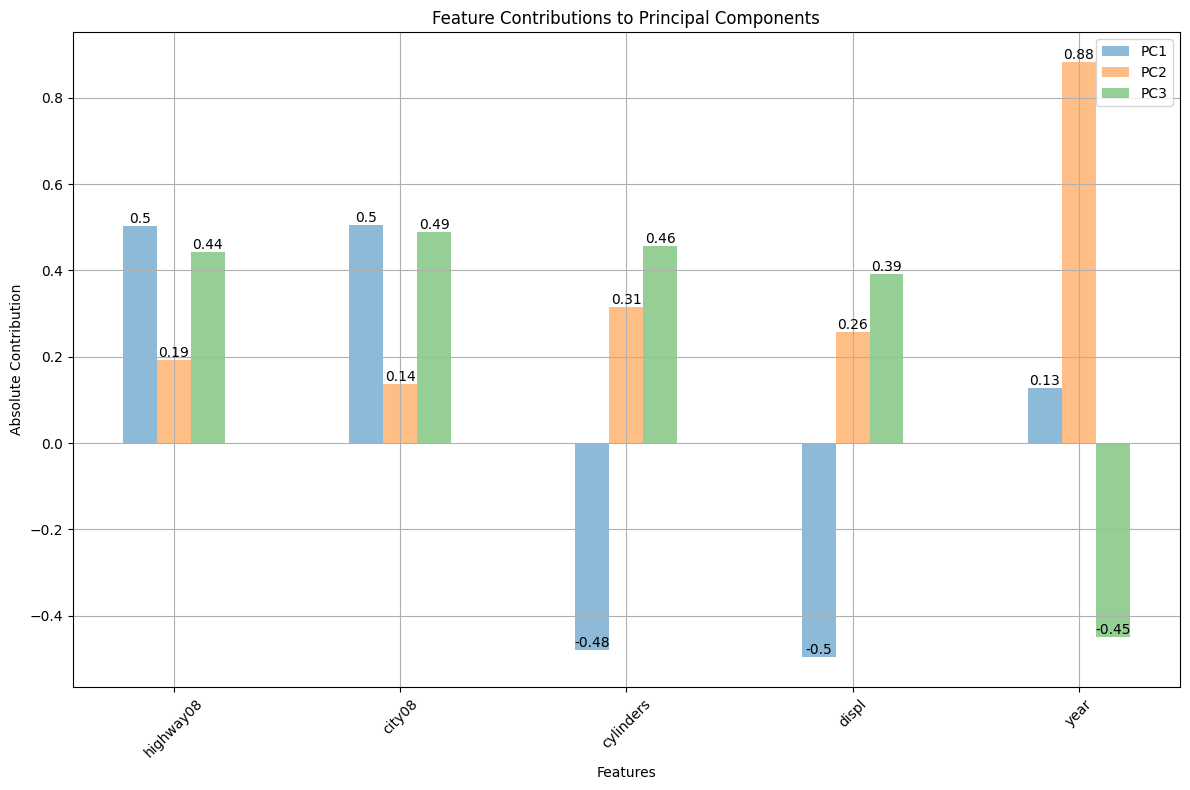

In [58]:
# Create a DataFrame to hold the PCA components and their contributions
components_df = pd.DataFrame(pca.components_, columns=car_data[scalars].columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])
# Calculate the absolute contributions for better visualization
abs_components_df = components_df

# Plot the contributions of each feature to the principal components
plt.figure(figsize=(12, 8))
x = np.arange(len(abs_components_df.columns))  # the label locations
width = 0.15  # the width of the bars

for i in range(abs_components_df.shape[0]):
    bars = plt.bar(x + i * width, abs_components_df.iloc[i], width, label=f'PC{i+1}', alpha=0.5)
    # Annotate each bar with its contribution value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Features')
plt.ylabel('Absolute Contribution')
plt.title('Feature Contributions to Principal Components')
plt.xticks(x + width * (abs_components_df.shape[0] - 1) / 2, abs_components_df.columns, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [59]:
from sklearn.preprocessing import OneHotEncoder
# one hot encode categories
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(car_data[categories])
one_hot_encoded = pd.DataFrame(one_hot_encoded)
one_hot_encoded

# combine PCA result with one hot encoded categories
# transformed_data = pd.concat([pca_result, one_hot_encoded], axis=1)
transformed_data = pca_result
transformed_data.shape

(45544, 3)

OPTICS - car.csv

In [60]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(car_data[scalars])

In [61]:
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_data = encoder.fit_transform(car_data[categories])

c:\Users\32147\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [62]:
X = np.hstack((scaled_data, encoded_data))

In [63]:
optics = OPTICS(min_samples=20, max_eps=1.5, metric='euclidean', cluster_method='xi', xi=0.05)
optics_labels = optics.fit_predict(X)


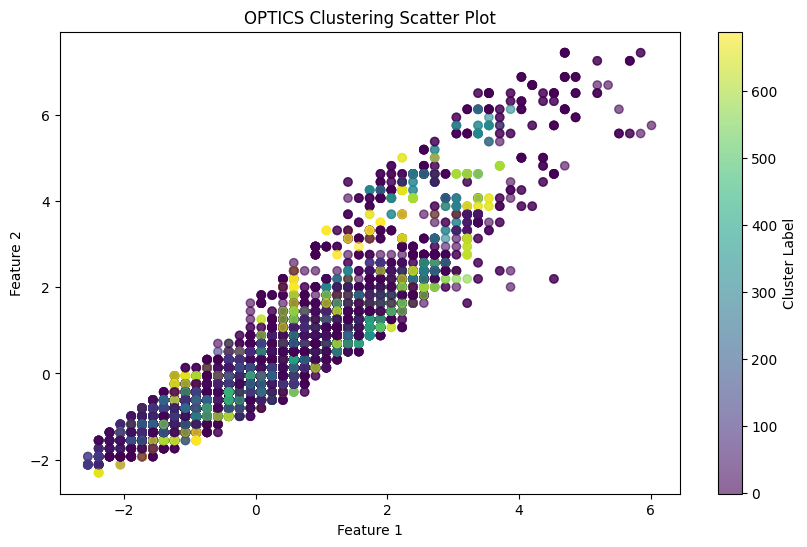

In [64]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=optics_labels, cmap='viridis', alpha=0.6)
plt.title('OPTICS Clustering Scatter Plot')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

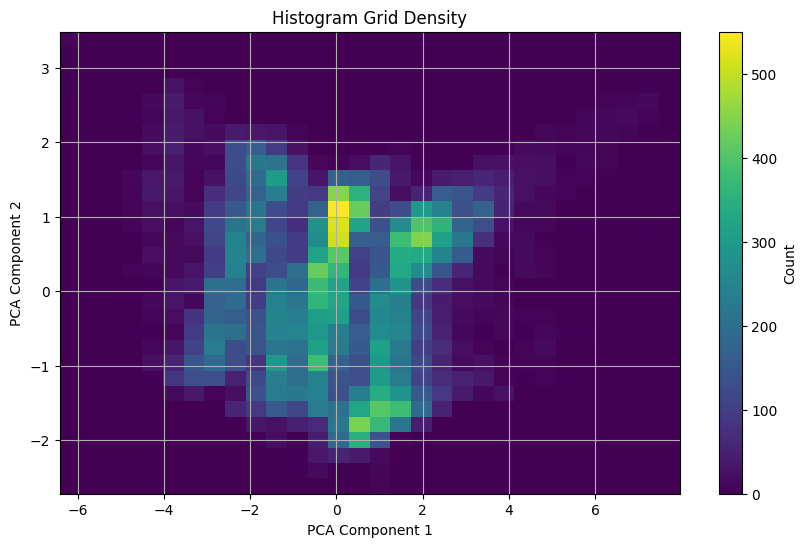

In [68]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist2d(pca_result[0], pca_result[1], bins=30, cmap='viridis')
plt.colorbar(label='Count')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Histogram Grid Density')
plt.grid(True)
plt.show()


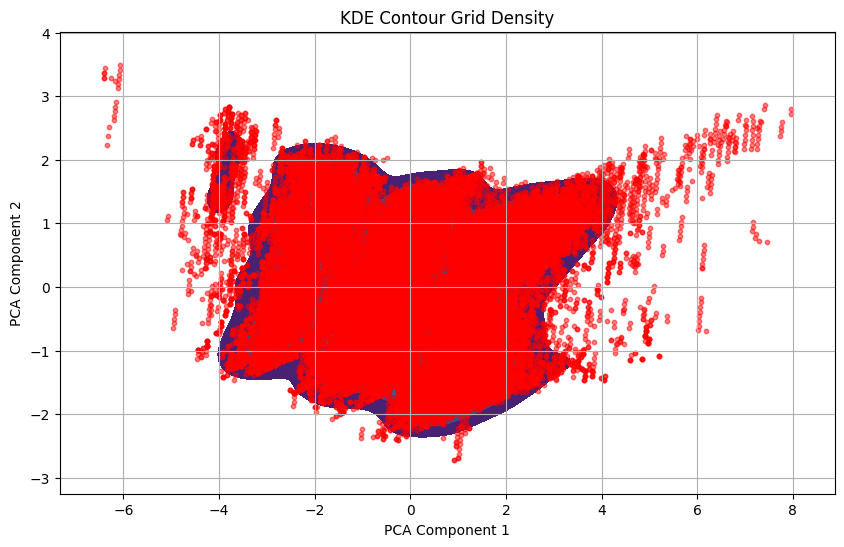

In [69]:
# KDE density
plt.figure(figsize=(10, 6))
sns.kdeplot(x=pca_result[0], y=pca_result[1], cmap='viridis', fill=True)
plt.scatter(pca_result[0], pca_result[1], color='red', s=10, alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KDE Contour Grid Density')
plt.grid(True)
plt.show()

In [70]:
# Silhouette score
silhouette = silhouette_score(X, optics_labels)
print(f'Silhouette Score: {silhouette:.4f}')

# Davies-bouldin index
db_index = davies_bouldin_score(X, optics_labels)
print(f'Davies-Bouldin Index: {db_index:.4f}')

# Calinski-harabasz index
ch_index = calinski_harabasz_score(X, optics_labels)
print(f'Calinski-Harabasz Index: {ch_index:.4f}')


Silhouette Score: -0.0116
Davies-Bouldin Index: 1.2511
Calinski-Harabasz Index: 69.6003


OPTICS - customer.csv

In [71]:
customer_data = pd.read_csv('data/customer.csv', sep=',', header=0)

customer_data['CustomerID'] = customer_data['CustomerID'].astype(int)
customer_data['Age'] = customer_data['Age'].astype(int)
customer_data['Annual Income (k$)'] = customer_data['Annual Income (k$)'].astype(int)
customer_data['Spending Score (1-100)'] = customer_data['Spending Score (1-100)'].astype(int)


In [72]:
# One-Hot for Gender
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
gender_encoded = one_hot_encoder.fit_transform(customer_data[['Gender']])
gender_encoded = pd.DataFrame(gender_encoded, columns=['Gender_Male'])


In [73]:
scaler = StandardScaler()
scalars = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
numeric = scaler.fit_transform(customer_data[scalars])

Number of Components to explain 95% Variance: 3


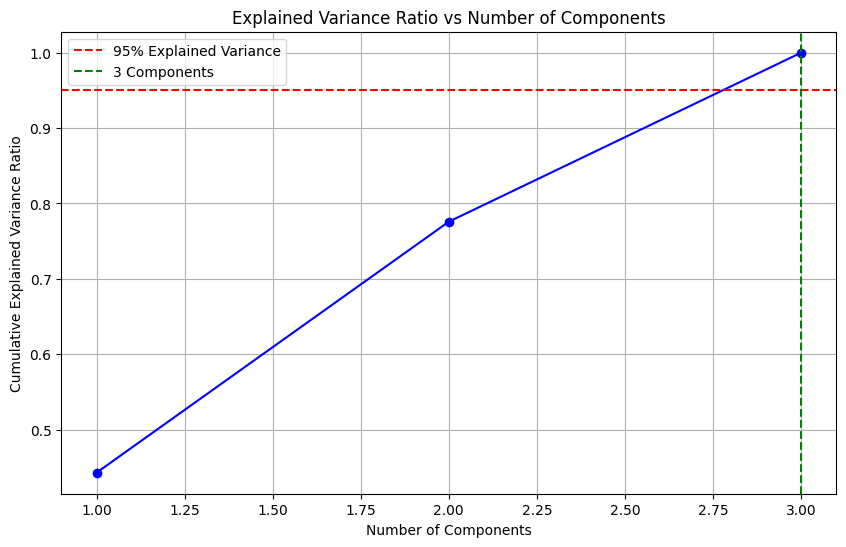

In [74]:
pca = PCA()
pca_result = pca.fit_transform(numeric)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f'Number of Components to explain 95% Variance: {n_components_95}')

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Components')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# Refit pca
pca = PCA(n_components=n_components_95)
pca_result = pca.fit_transform(numeric)
pca_result = pd.DataFrame(pca_result)

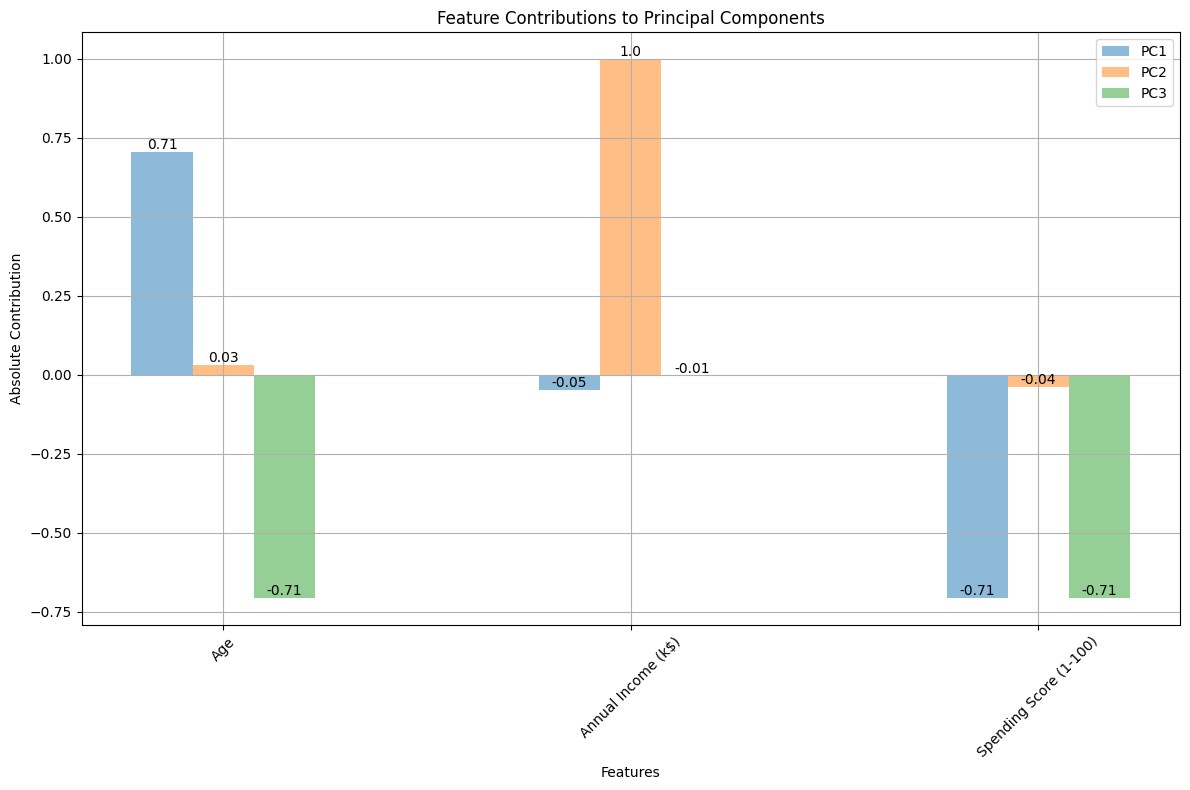

In [76]:
components_df = pd.DataFrame(pca.components_, columns=customer_data[scalars].columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])
abs_components_df = components_df

# Plot the contributions of each feature to the principal components
plt.figure(figsize=(12, 8))
x = np.arange(len(abs_components_df.columns))
width = 0.15

for i in range(abs_components_df.shape[0]):
    bars = plt.bar(x + i * width, abs_components_df.iloc[i], width, label=f'PC{i+1}', alpha=0.5)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Features')
plt.ylabel('Absolute Contribution')
plt.title('Feature Contributions to Principal Components')
plt.xticks(x + width * (abs_components_df.shape[0] - 1) / 2, abs_components_df.columns, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
optics = OPTICS(min_samples=5, max_eps=2, metric='euclidean', cluster_method='xi', xi=0.05)
optics_labels = optics.fit_predict(pca_result)

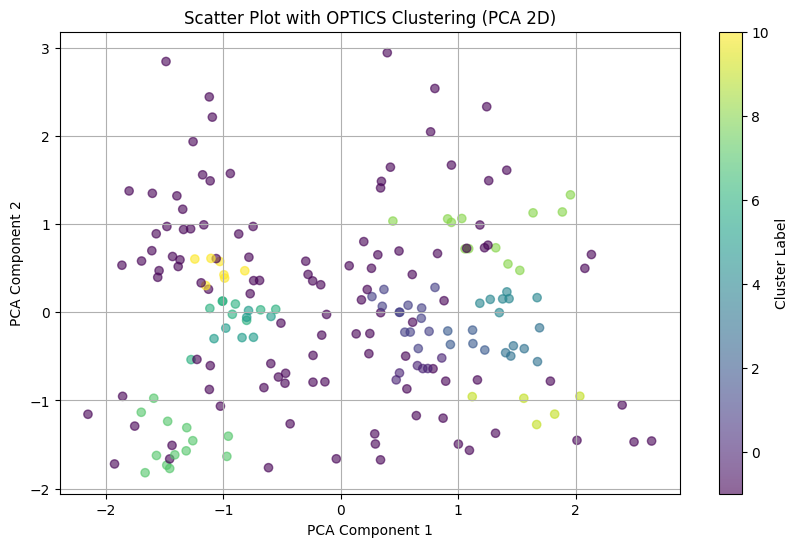

In [78]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[0], pca_result[1], c=optics_labels, cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatter Plot with OPTICS Clustering (PCA 2D)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

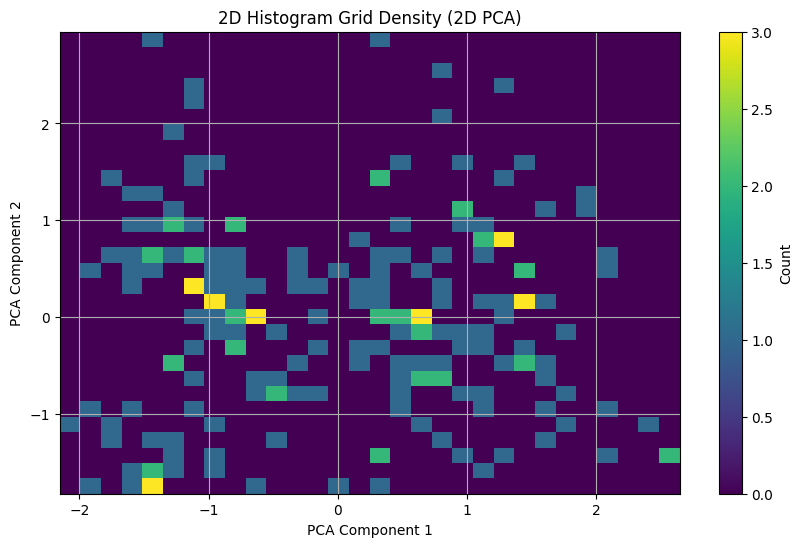

In [79]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist2d(pca_result[0], pca_result[1], bins=30, cmap='viridis')
plt.colorbar(label='Count')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D Histogram Grid Density (2D PCA)')
plt.grid(True)
plt.show()

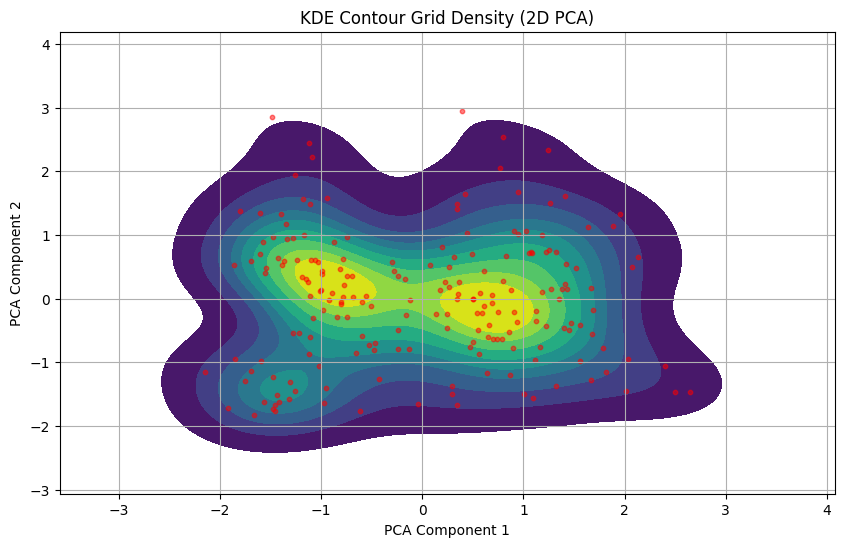

In [80]:
# KDE density 
plt.figure(figsize=(10, 6))
sns.kdeplot(x=pca_result[0], y=pca_result[1], cmap='viridis', fill=True)
plt.scatter(pca_result[0], pca_result[1], color='red', s=10, alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KDE Contour Grid Density (2D PCA)')
plt.grid(True)
plt.show()

In [81]:
# Silhouette score
silhouette = silhouette_score(pca_result, optics_labels)
print(f'Silhouette Score (PCA 3D): {silhouette:.4f}')

# Davies-bouldin index
db_index = davies_bouldin_score(pca_result, optics_labels)
print(f'Davies-Bouldin Index (PCA 3D): {db_index:.4f}')

# Calinski-harabasz index
ch_index = calinski_harabasz_score(pca_result, optics_labels)
print(f'Calinski-Harabasz Index (PCA 3D): {ch_index:.4f}')

Silhouette Score (PCA 3D): -0.0961
Davies-Bouldin Index (PCA 3D): 1.4269
Calinski-Harabasz Index (PCA 3D): 10.7699
